In [51]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [52]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
#from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [53]:
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

In [54]:
# Walk through each directory
dataset = fr'/kaggle/input/album-covers-dataset/images labeled/images labeled'

In [55]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

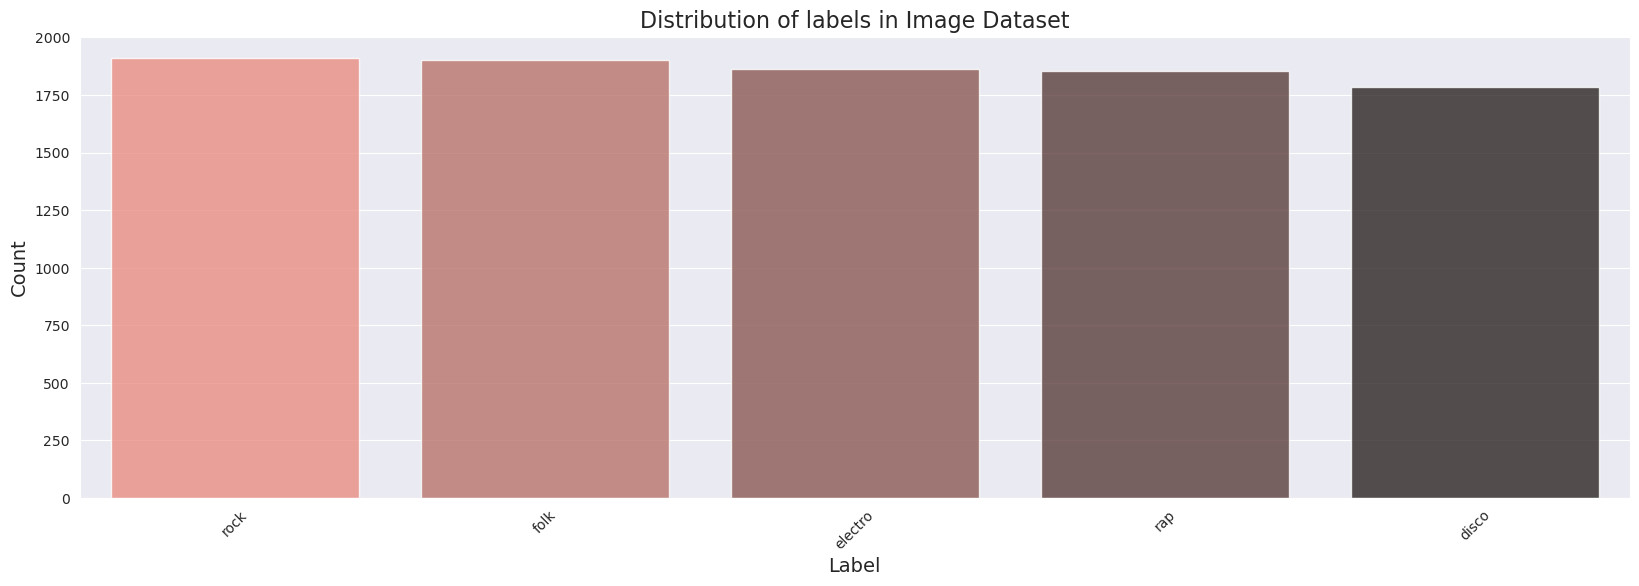

In [56]:
# Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

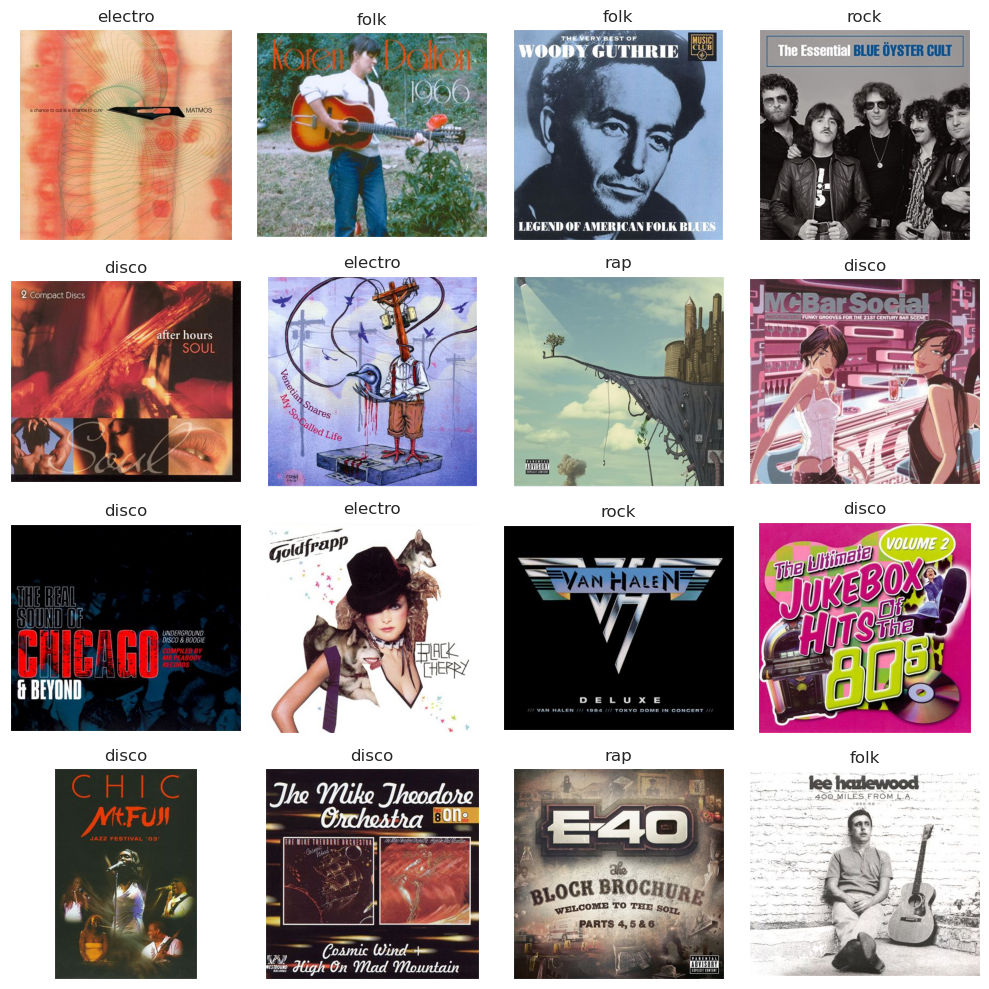

In [57]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [58]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

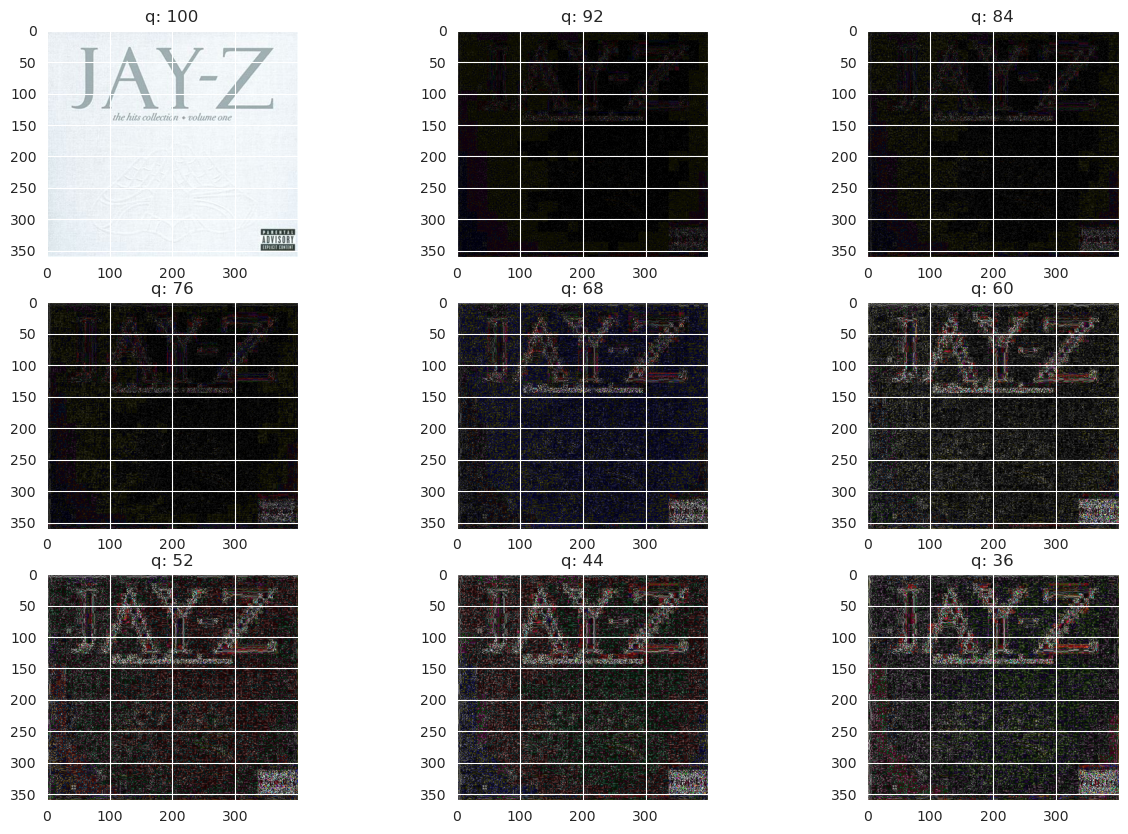

In [59]:
# View random sample from the dataset
p = random_sample(fr'/kaggle/input/album-covers-dataset/images labeled/images labeled/rap')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [60]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [61]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [62]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5959 validated image filenames belonging to 5 classes.
Found 1489 validated image filenames belonging to 5 classes.
Found 1863 validated image filenames belonging to 5 classes.


In [63]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [64]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [65]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [67]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/20


2023-07-04 17:25:41.113689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


373/373 [==============================] - 37s 79ms/step - loss: 2.0511 - accuracy: 0.2094 - val_loss: 1.6021 - val_accuracy: 0.2216 - lr: 1.0000e-04
Epoch 2/20
373/373 [==============================] - 27s 73ms/step - loss: 1.6124 - accuracy: 0.2348 - val_loss: 1.5889 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 3/20
373/373 [==============================] - 27s 73ms/step - loss: 1.5881 - accuracy: 0.2492 - val_loss: 1.5764 - val_accuracy: 0.2592 - lr: 1.0000e-04
Epoch 4/20
373/373 [==============================] - 27s 73ms/step - loss: 1.5839 - accuracy: 0.2579 - val_loss: 1.5668 - val_accuracy: 0.2693 - lr: 1.0000e-04
Epoch 5/20
373/373 [==============================] - 29s 77ms/step - loss: 1.5686 - accuracy: 0.2784 - val_loss: 1.5599 - val_accuracy: 0.2874 - lr: 1.0000e-04
Epoch 6/20
373/373 [==============================] - 28s 75ms/step - loss: 1.5531 - accuracy: 0.2855 - val_loss: 1.5420 - val_accuracy: 0.2888 - lr: 1.0000e-04
Epoch 7/20
373/373 [=========================

In [68]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.37940
Test Accuracy: 41.98%


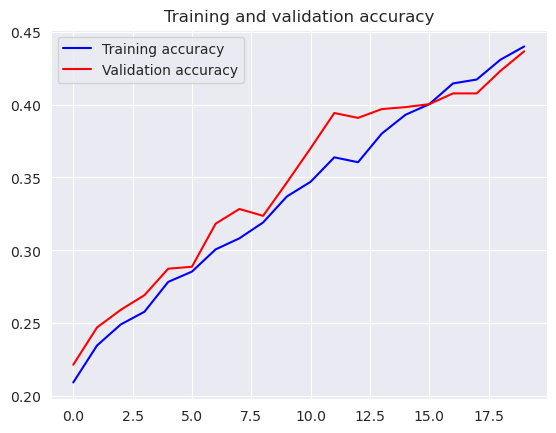

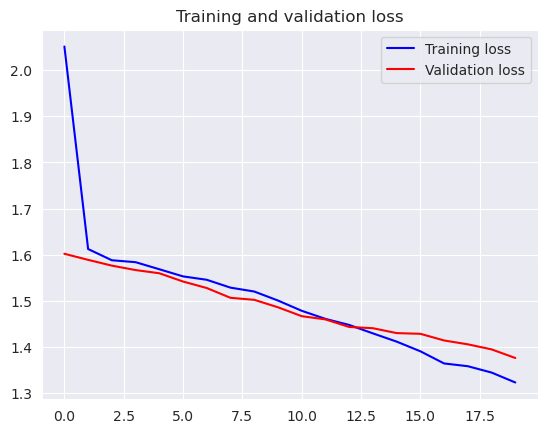

In [69]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [70]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

117/117 [==============================] - 8s 57ms/step
The first 5 predictions: ['electro', 'disco', 'electro', 'rap', 'folk']


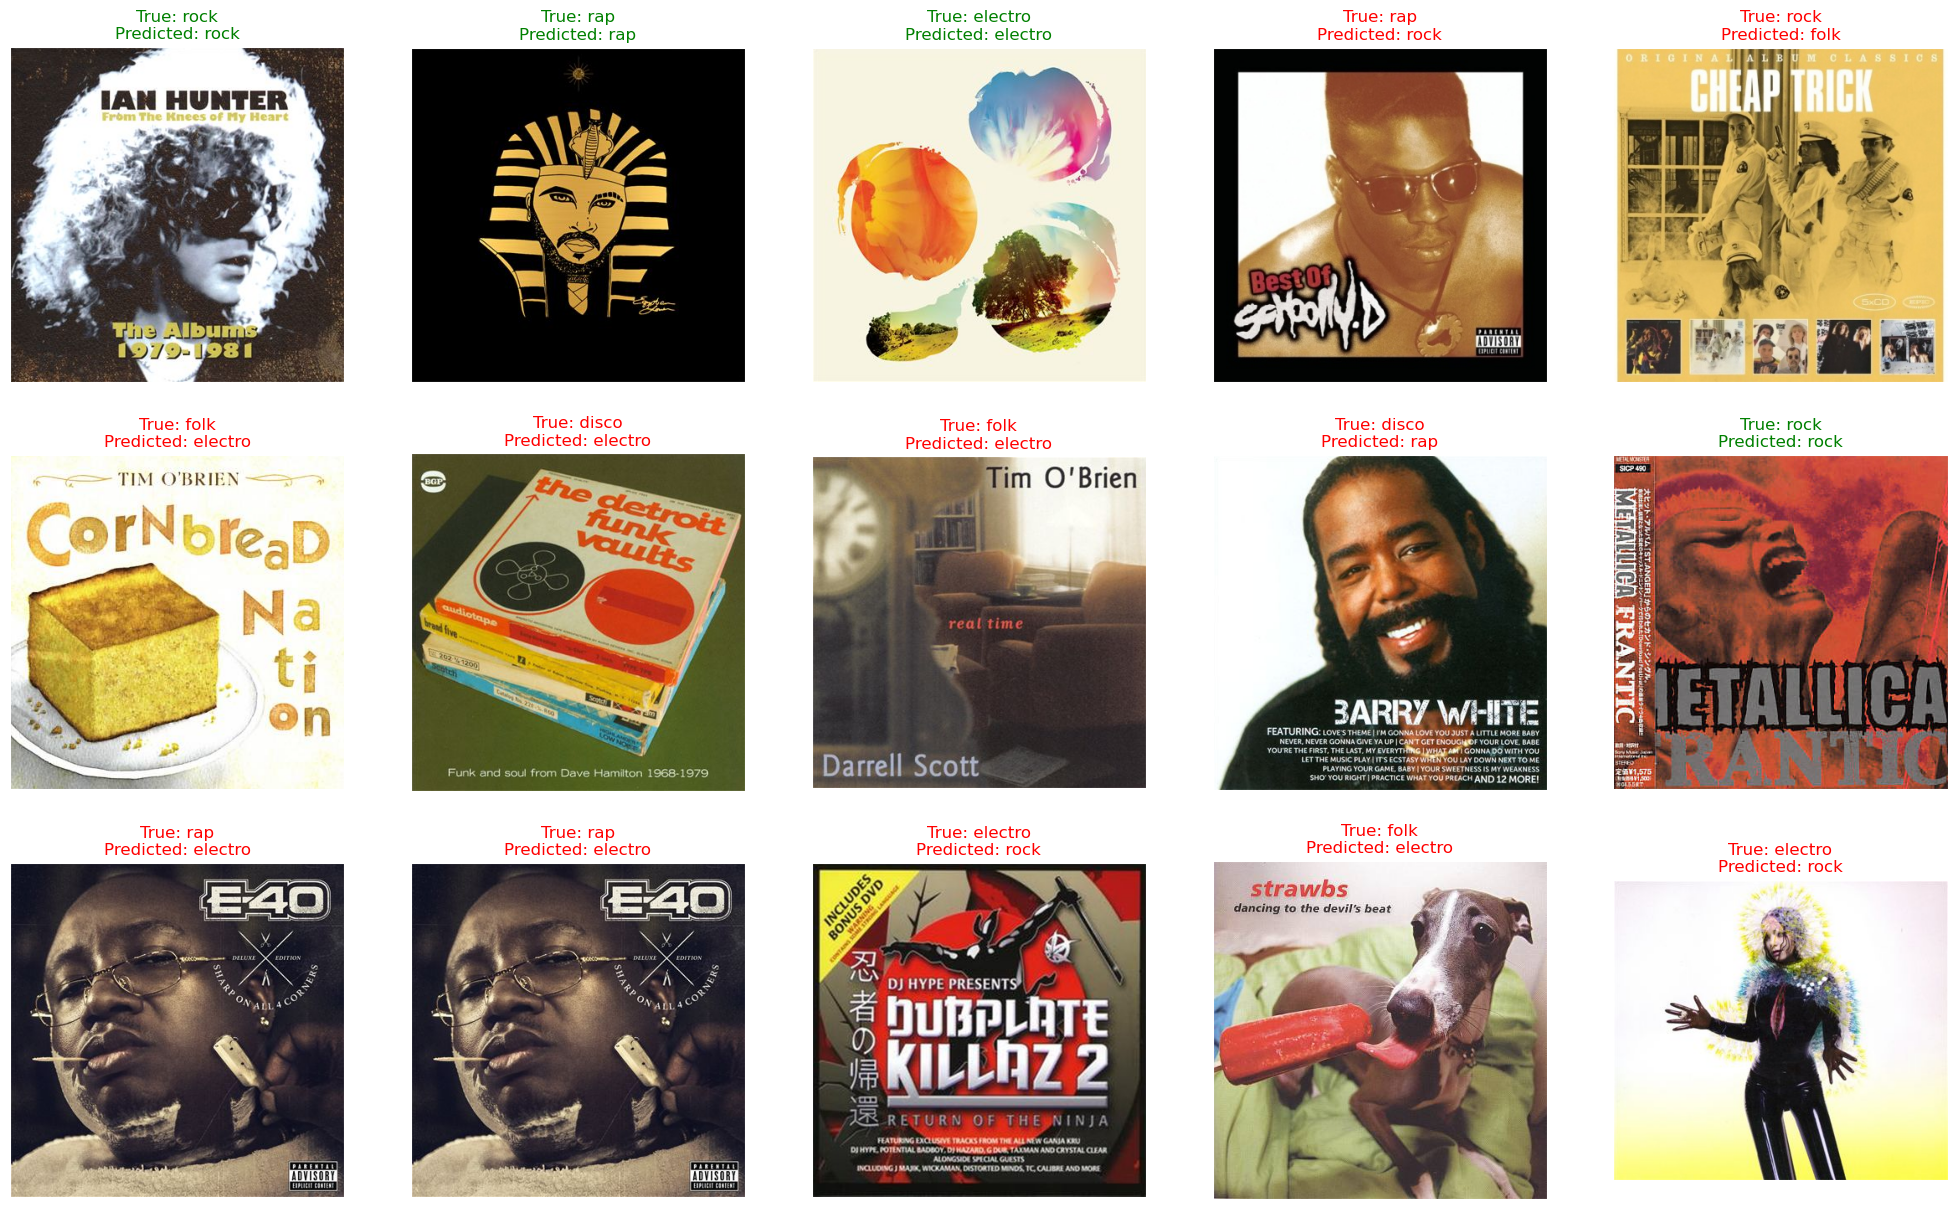

<Figure size 640x480 with 0 Axes>

In [71]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [72]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       disco       0.49      0.28      0.35       360
     electro       0.45      0.53      0.49       381
        folk       0.41      0.45      0.43       353
         rap       0.43      0.47      0.45       362
        rock       0.35      0.38      0.36       407

    accuracy                           0.42      1863
   macro avg       0.43      0.42      0.42      1863
weighted avg       0.43      0.42      0.42      1863



In [73]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
disco          0.487685  0.275000  0.351687   360.000000
electro        0.451685  0.527559  0.486683   381.000000
folk           0.414062  0.450425  0.431479   353.000000
rap            0.430380  0.469613  0.449141   362.000000
rock           0.350917  0.375921  0.362989   407.000000
accuracy       0.419753  0.419753  0.419753     0.419753
macro avg      0.426946  0.419704  0.416396  1863.000000
weighted avg   0.425359  0.419753  0.415819  1863.000000

VGG16

In [74]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load the pretained model
pretrained_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [75]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/20
373/373 [==============================] - 34s 86ms/step - loss: 21.8556 - accuracy: 0.2067 - val_loss: 3.7656 - val_accuracy: 0.2129 - lr: 1.0000e-04
Epoch 2/20
373/373 [==============================] - 32s 86ms/step - loss: 4.6455 - accuracy: 0.2004 - val_loss: 1.9599 - val_accuracy: 0.2075 - lr: 1.0000e-04
Epoch 3/20
373/373 [==============================] - 32s 87ms/step - loss: 2.3849 - accuracy: 0.2217 - val_loss: 1.7472 - val_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 4/20
373/373 [==============================] - 37s 98ms/step - loss: 1.9467 - accuracy: 0.2234 - val_loss: 1.6756 - val_accuracy: 0.2391 - lr: 1.0000e-04
Epoch 5/20
373/373 [==============================] - 33s 88ms/step - loss: 1.7945 - accuracy: 0.2160 - val_loss: 1.6466 - val_accuracy: 0.2337 - lr: 1.0000e-04
Epoch 6/20
373/373 [==============================] - 33s 88ms/step - loss: 1.7421 - accuracy: 0.2136 - val_loss: 1.6314 - val_accuracy: 0.2324 - lr: 1.0000e-04
Epoch 7/20
373/373 [=============

In [76]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.60476
Test Accuracy: 21.20%


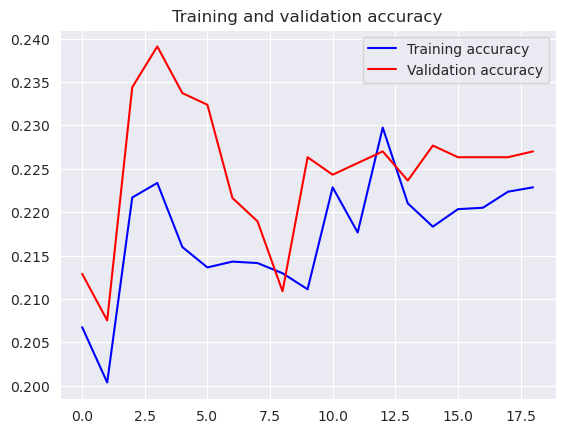

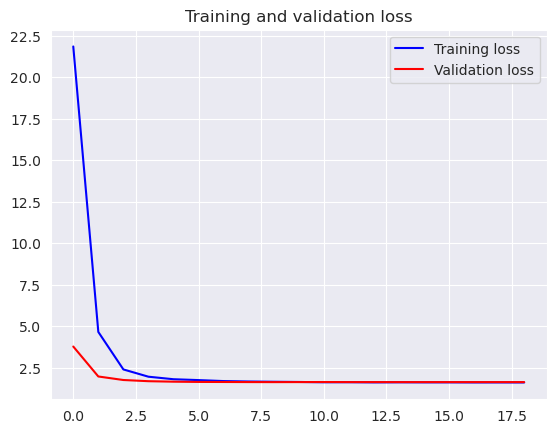

In [77]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [83]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

117/117 [==============================] - 8s 60ms/step
The first 5 predictions: ['rock', 'rock', 'rock', 'rap', 'rock']


In [84]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       disco       0.00      0.00      0.00       360
     electro       0.67      0.01      0.01       381
        folk       0.22      0.01      0.01       353
         rap       0.27      0.01      0.02       362
        rock       0.22      0.99      0.36       407

    accuracy                           0.22      1863
   macro avg       0.28      0.20      0.08      1863
weighted avg       0.28      0.22      0.09      1863



In [85]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
disco          0.000000  0.000000  0.000000   360.000000
electro        0.666667  0.005249  0.010417   381.000000
folk           0.222222  0.005666  0.011050   353.000000
rap            0.272727  0.008287  0.016086   362.000000
rock           0.218597  0.987715  0.357970   407.000000
accuracy       0.219538  0.219538  0.219538     0.219538
macro avg      0.276043  0.201383  0.079104  1863.000000
weighted avg   0.279195  0.219538  0.085553  1863.000000

In [86]:
#Inception

In [87]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Load the pretained model
pretrained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [88]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/20
373/373 [==============================] - 36s 79ms/step - loss: 8.2549 - accuracy: 0.2078 - val_loss: 1.6342 - val_accuracy: 0.2189 - lr: 1.0000e-04
Epoch 2/20
373/373 [==============================] - 27s 71ms/step - loss: 1.6476 - accuracy: 0.2123 - val_loss: 1.6218 - val_accuracy: 0.2095 - lr: 1.0000e-04
Epoch 3/20
373/373 [==============================] - 27s 72ms/step - loss: 1.6167 - accuracy: 0.2126 - val_loss: 1.6189 - val_accuracy: 0.2116 - lr: 1.0000e-04
Epoch 4/20
373/373 [==============================] - 27s 72ms/step - loss: 1.6166 - accuracy: 0.2083 - val_loss: 1.6188 - val_accuracy: 0.2082 - lr: 1.0000e-04
Epoch 5/20
373/373 [==============================] - 26s 70ms/step - loss: 1.6087 - accuracy: 0.2103 - val_loss: 1.6190 - val_accuracy: 0.2048 - lr: 1.0000e-04
Epoch 6/20
373/373 [==============================] - 27s 72ms/step - loss: 1.6096 - accuracy: 0.2091 - val_loss: 1.6188 - val_accuracy: 0.2069 - lr: 1.0000e-04
Epoch 7/20
373/373 [==============

In [89]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.60672
Test Accuracy: 19.54%


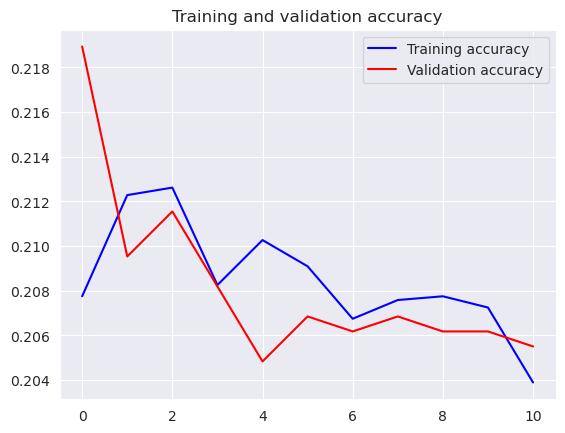

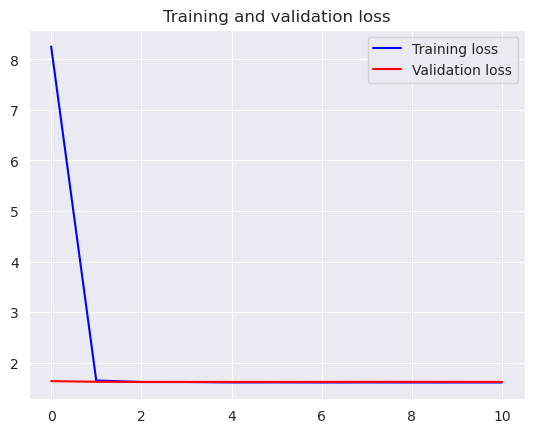

In [90]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [91]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

117/117 [==============================] - 8s 57ms/step
The first 5 predictions: ['folk', 'folk', 'folk', 'folk', 'folk']


In [92]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       disco       0.00      0.00      0.00       360
     electro       0.00      0.00      0.00       381
        folk       0.19      0.99      0.32       353
         rap       0.45      0.04      0.07       362
        rock       0.17      0.00      0.00       407

    accuracy                           0.20      1863
   macro avg       0.16      0.21      0.08      1863
weighted avg       0.16      0.20      0.08      1863



In [93]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
disco          0.000000  0.000000  0.000000   360.000000
electro        0.000000  0.000000  0.000000   381.000000
folk           0.191864  0.988669  0.321363   353.000000
rap            0.451613  0.038674  0.071247   362.000000
rock           0.166667  0.002457  0.004843   407.000000
accuracy       0.195384  0.195384  0.195384     0.195384
macro avg      0.162029  0.205960  0.079490  1863.000000
weighted avg   0.160518  0.195384  0.075794  1863.000000

In [94]:
#ResNet50

In [95]:
from tensorflow.keras.applications import ResNet50

# Load the pretained model
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [96]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/20
373/373 [==============================] - 37s 86ms/step - loss: 4.5699 - accuracy: 0.2136 - val_loss: 1.7798 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 2/20
373/373 [==============================] - 30s 80ms/step - loss: 2.1847 - accuracy: 0.2188 - val_loss: 1.6342 - val_accuracy: 0.2458 - lr: 1.0000e-04
Epoch 3/20
373/373 [==============================] - 30s 80ms/step - loss: 1.8188 - accuracy: 0.2153 - val_loss: 1.6078 - val_accuracy: 0.2518 - lr: 1.0000e-04
Epoch 4/20
373/373 [==============================] - 30s 79ms/step - loss: 1.7313 - accuracy: 0.2225 - val_loss: 1.5992 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 5/20
373/373 [==============================] - 30s 80ms/step - loss: 1.6910 - accuracy: 0.2318 - val_loss: 1.5961 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 6/20
373/373 [==============================] - 31s 82ms/step - loss: 1.6628 - accuracy: 0.2316 - val_loss: 1.5924 - val_accuracy: 0.2572 - lr: 1.0000e-04
Epoch 7/20
373/373 [==============

In [97]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.59225
Test Accuracy: 26.95%


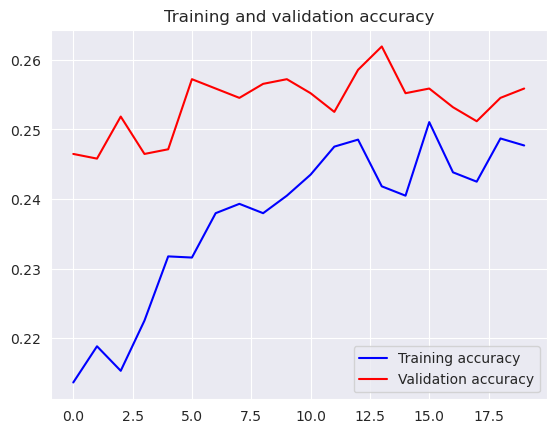

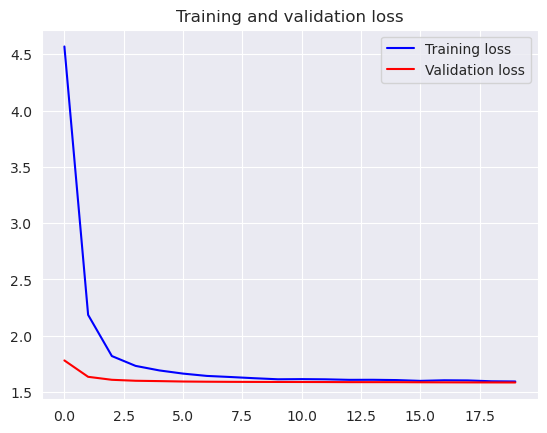

In [98]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [99]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

117/117 [==============================] - 8s 58ms/step
The first 5 predictions: ['electro', 'rock', 'rock', 'rock', 'rock']


In [100]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       disco       0.33      0.05      0.09       360
     electro       0.33      0.45      0.38       381
        folk       0.39      0.18      0.24       353
         rap       0.20      0.05      0.08       362
        rock       0.22      0.57      0.32       407

    accuracy                           0.27      1863
   macro avg       0.29      0.26      0.22      1863
weighted avg       0.29      0.27      0.23      1863



In [101]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
disco          0.327273  0.050000  0.086747   360.000000
electro        0.330754  0.448819  0.380846   381.000000
folk           0.386503  0.178470  0.244186   353.000000
rap            0.200000  0.052486  0.083151   362.000000
rock           0.223621  0.567568  0.320833   407.000000
accuracy       0.269458  0.269458  0.269458     0.269458
macro avg      0.293630  0.259469  0.223153  1863.000000
weighted avg   0.291833  0.269458  0.227165  1863.000000

In [102]:
#EfficientNet

In [103]:
pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [104]:
import efficientnet.keras as efn

In [105]:
from tensorflow.keras.applications import ResNet50

# Load the pretained model
pretrained_model = efn.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258434480/258434480 [==============================] - 3s 0us/step


In [110]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/20


2023-07-04 18:16:22.570800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


373/373 [==============================] - 117s 251ms/step - loss: 1523.5889 - accuracy: 0.1980 - val_loss: 3.2038 - val_accuracy: 0.2062 - lr: 1.0000e-04
Epoch 2/20
373/373 [==============================] - 86s 231ms/step - loss: 274.0399 - accuracy: 0.2027 - val_loss: 2.0722 - val_accuracy: 0.2001 - lr: 1.0000e-04
Epoch 3/20
373/373 [==============================] - 86s 231ms/step - loss: 158.8068 - accuracy: 0.1985 - val_loss: 1.8142 - val_accuracy: 0.1995 - lr: 1.0000e-04
Epoch 4/20
373/373 [==============================] - 86s 231ms/step - loss: 80.3920 - accuracy: 0.2004 - val_loss: 1.7027 - val_accuracy: 0.2035 - lr: 1.0000e-04
Epoch 5/20
373/373 [==============================] - 86s 232ms/step - loss: 49.5607 - accuracy: 0.1999 - val_loss: 1.6663 - val_accuracy: 0.2129 - lr: 1.0000e-04
Epoch 6/20
373/373 [==============================] - 86s 232ms/step - loss: 44.6514 - accuracy: 0.2012 - val_loss: 1.6357 - val_accuracy: 0.2048 - lr: 1.0000e-04
Epoch 7/20
373/373 [========

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df